In [1]:
#!pip install keras

In [2]:
#!pip install matplotlib

In [3]:
#!pip install seaborn
#!pip install numpy
#!pip install scipy
#!pip install pandas

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp

%matplotlib inline

In [5]:
import pandas as pd

data = pd.read_csv('L:/LabsAI/AI_1/data/Iris.csv', index_col='Id')
print(f'Всего данных: {data.shape[0]}')
data.head()

Всего данных: 150


,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
Id,,,,,
1,5.1,3.5,1.4,0.2,Iris-setosa
2,4.9,3.0,1.4,0.2,Iris-setosa
3,4.7,3.2,1.3,0.2,Iris-setosa
4,4.6,3.1,1.5,0.2,Iris-setosa
5,5.0,3.6,1.4,0.2,Iris-setosa


In [6]:
#!pip install sklearn

In [7]:
import sklearn.pipeline as pipeline
import sklearn.preprocessing as preproc
from sklearn.base import BaseEstimator, TransformerMixin
from keras.utils import to_categorical

Using TensorFlow backend.


In [8]:
class FillNa(TransformerMixin, BaseEstimator):
    def fit(self, X: pd.DataFrame, y=None):
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        return X.interpolate(method='cubic').fillna(method='pad').dropna()
    
class DropOutlet(TransformerMixin, BaseEstimator): 
    def fit(self, X: pd.DataFrame, y=None):
        self.std = X.std()
        self.columns = self.std.index.values
        return self
    
    def transform(self, X: pd.DataFrame, y=None) -> pd.DataFrame:
        X_cols = X[self.columns]
        return X[ (X_cols - X_cols.mean()).abs() <= 3*self.std ].dropna()

class PandasToNumpy(BaseEstimator):
    def fit(self, X : pd.DataFrame = None, y=None):
        return self
    def transform(self, X: pd.DataFrame, y=None) -> np.ndarray:
        return X.values
    
class SparseToArray(TransformerMixin, BaseEstimator):
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return X.toarray()

class ModifyLabelEncoder(preproc.LabelEncoder):
    def fit(self, X, y=None):
        return super().fit(X)
    def transform(self, X, y=None):
        print(1)
        return super().transform(X)
    def fit_transform(self, X, y=None):
        return super().fit_transform(X)
    
class ExpandDims(TransformerMixin, BaseEstimator):
    def __init__(self, axis):
        self.axis = axis
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        return np.expand_dims(X, axis=self.axis)

In [9]:
X_data = data[data.columns[:-1]].copy()
X_data = pd.get_dummies(X_data)

Y_data = data[data.columns[-1]].copy()

fill_na_pipe = pipeline.Pipeline([
    ('fill', FillNa()),
])

pipe_outlet = pipeline.Pipeline([
    ('fill_na', fill_na_pipe),
    ('drop_outlet', DropOutlet()),
])

outletless_data_X = pipe_outlet.fit_transform(X_data)
outletless_data_Y = Y_data[ fill_na_pipe.fit_transform(Y_data).index.isin(outletless_data_X.index) ]

pipe_x = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('norm', preproc.MinMaxScaler())
])

pipe_y = pipeline.Pipeline([
    ('to_matrix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
    ('expand_dims', ExpandDims(axis=1)),
    ('one_hot_encoder', preproc.OneHotEncoder(sparse=False))
])

number_data_read_X = pipe_x.fit_transform(outletless_data_X)
number_data_read_Y = pipe_y.fit_transform(outletless_data_Y)

print(number_data_read_X.shape, number_data_read_Y.shape)

(149, 4) (149, 3)


D:\Anaconda3\envs\py36_env\lib\site-packages\sklearn\preprocessing\_encoders.py:368: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [10]:
number_data_read_X[:10,:], number_data_read_Y[::10]

(array([[0.22222222, 0.68181818, 0.06779661, 0.04166667],
        [0.16666667, 0.45454545, 0.06779661, 0.04166667],
        [0.11111111, 0.54545455, 0.05084746, 0.04166667],
        [0.08333333, 0.5       , 0.08474576, 0.04166667],
        [0.19444444, 0.72727273, 0.06779661, 0.04166667],
        [0.30555556, 0.86363636, 0.11864407, 0.125     ],
        [0.08333333, 0.63636364, 0.06779661, 0.08333333],
        [0.19444444, 0.63636364, 0.08474576, 0.04166667],
        [0.02777778, 0.40909091, 0.06779661, 0.04166667],
        [0.16666667, 0.5       , 0.08474576, 0.        ]]),
 array([[1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 1., 0.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.],
        [0., 0., 1.]]))

In [11]:
X_train = number_data_read_X
Y_train = number_data_read_Y
X_train.shape, Y_train.shape

((149, 4), (149, 3))

In [12]:
import keras
from keras.layers import Dense
from keras.models import Sequential
from keras import activations
from keras.optimizers import Adam, RMSprop
from keras.losses import categorical_crossentropy
from keras.metrics import categorical_accuracy

In [13]:
model = Sequential()
model.add(Dense(10, activation=activations.relu, input_dim=X_train.shape[1]))
model.add(Dense(Y_train.shape[1], activation=activations.softmax))
model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])

In [14]:
model.fit(X_train, Y_train, verbose=2, epochs=100, batch_size=3)

Epoch 1/100
 - 1s - loss: 1.0463 - categorical_accuracy: 0.3221
Epoch 2/100
 - 0s - loss: 1.0145 - categorical_accuracy: 0.3691
Epoch 3/100
 - 0s - loss: 0.9836 - categorical_accuracy: 0.5369
Epoch 4/100
 - 0s - loss: 0.9524 - categorical_accuracy: 0.6174
Epoch 5/100
 - 0s - loss: 0.9193 - categorical_accuracy: 0.6644
Epoch 6/100
 - 0s - loss: 0.8826 - categorical_accuracy: 0.6644
Epoch 7/100
 - 0s - loss: 0.8353 - categorical_accuracy: 0.6644
Epoch 8/100
 - 0s - loss: 0.7891 - categorical_accuracy: 0.6644
Epoch 9/100
 - 0s - loss: 0.7491 - categorical_accuracy: 0.6644
Epoch 10/100
 - 0s - loss: 0.7125 - categorical_accuracy: 0.6644
Epoch 11/100
 - 0s - loss: 0.6798 - categorical_accuracy: 0.6644
Epoch 12/100
 - 0s - loss: 0.6508 - categorical_accuracy: 0.6644
Epoch 13/100
 - 0s - loss: 0.6242 - categorical_accuracy: 0.6644
Epoch 14/100
 - 0s - loss: 0.6006 - categorical_accuracy: 0.6644
Epoch 15/100
 - 0s - loss: 0.5792 - categorical_accuracy: 0.6644
Epoch 16/100
 - 0s - loss: 0.5623 

In [15]:
model.evaluate(X_train, Y_train)

149/149 [==============================] - 0s 383us/step


[0.18979540017227198, 0.9597315440241923]

In [16]:
# 5
from keras import callbacks

In [17]:
XY_data = np.hstack( (number_data_read_X, number_data_read_Y) ).transpose((0,1))
np.random.shuffle(XY_data)

point_split = round(XY_data.shape[0] * 0.8)
train_data = XY_data[:point_split]
test_data = XY_data[point_split:]
print(f'Всего данных: {XY_data.shape[0]}')
print(f'Тренировочных данных: {train_data.shape[0]}')
print(f'Тестовых данных: {test_data.shape[0]}')

#Тренировочные
X_train = train_data[:, :number_data_read_X.shape[1] ]
Y_train = train_data[:, number_data_read_X.shape[1]: ]
print(f'Размер данных для тренировки (входные): {X_train.shape}')
print(f'Расмер данных для тренировки (выходные): {Y_train.shape}')

#Тестовые
X_test = test_data[:, :number_data_read_X.shape[1] ]
Y_test = test_data[:, number_data_read_X.shape[1]: ]
print(f'Размер данных для теста (входных): {X_test.shape}')
print(f'Размер данных для теста (выходных): {Y_test.shape}')

Всего данных: 149
Тренировочных данных: 119
Тестовых данных: 30
Размер данных для тренировки (входные): (119, 4)
Расмер данных для тренировки (выходные): (119, 3)
Размер данных для теста (входных): (30, 4)
Размер данных для теста (выходных): (30, 3)


In [18]:
def make_nn(input_len, output_len):
    model = Sequential()
    model.add(Dense(10, activation=activations.relu, input_dim=input_len))
    model.add(Dense(output_len, activation=activations.softmax))
    model.compile(Adam(), categorical_crossentropy, metrics=[categorical_accuracy])
    return model

In [19]:
model = make_nn(X_train.shape[1], Y_train.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=100,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[
        callbacks.History(),
    ]
)

Начинаем обучение сети
Train on 119 samples, validate on 30 samples
Epoch 1/100
119/119 [==============================] - 0s 2ms/step - loss: 1.1446 - categorical_accuracy: 0.1681 - val_loss: 1.1265 - val_categorical_accuracy: 0.2667
Epoch 2/100
119/119 [==============================] - 0s 336us/step - loss: 1.1077 - categorical_accuracy: 0.3193 - val_loss: 1.0970 - val_categorical_accuracy: 0.3333
Epoch 3/100
119/119 [==============================] - 0s 311us/step - loss: 1.0828 - categorical_accuracy: 0.3361 - val_loss: 1.0752 - val_categorical_accuracy: 0.3333
Epoch 4/100
119/119 [==============================] - 0s 303us/step - loss: 1.0658 - categorical_accuracy: 0.4202 - val_loss: 1.0572 - val_categorical_accuracy: 0.5333
Epoch 5/100
119/119 [==============================] - 0s 303us/step - loss: 1.0443 - categorical_accuracy: 0.5378 - val_loss: 1.0383 - val_categorical_accuracy: 0.7000
Epoch 6/100
119/119 [==============================] - 0s 277us/step - loss: 1.0258 - cat

Epoch 49/100
119/119 [==============================] - 0s 252us/step - loss: 0.3247 - categorical_accuracy: 0.9748 - val_loss: 0.3148 - val_categorical_accuracy: 0.9333
Epoch 50/100
119/119 [==============================] - 0s 252us/step - loss: 0.3205 - categorical_accuracy: 0.9748 - val_loss: 0.3109 - val_categorical_accuracy: 0.9333
Epoch 51/100
119/119 [==============================] - 0s 261us/step - loss: 0.3159 - categorical_accuracy: 0.9748 - val_loss: 0.3067 - val_categorical_accuracy: 0.9333
Epoch 52/100
119/119 [==============================] - 0s 252us/step - loss: 0.3107 - categorical_accuracy: 0.9748 - val_loss: 0.3029 - val_categorical_accuracy: 0.9333
Epoch 53/100
119/119 [==============================] - 0s 244us/step - loss: 0.3063 - categorical_accuracy: 0.9748 - val_loss: 0.2991 - val_categorical_accuracy: 0.9333
Epoch 54/100
119/119 [==============================] - 0s 252us/step - loss: 0.3021 - categorical_accuracy: 0.9748 - val_loss: 0.2951 - val_categoric

119/119 [==============================] - 0s 269us/step - loss: 0.1783 - categorical_accuracy: 0.9664 - val_loss: 0.1871 - val_categorical_accuracy: 0.9333
Epoch 98/100
119/119 [==============================] - 0s 261us/step - loss: 0.1757 - categorical_accuracy: 0.9748 - val_loss: 0.1847 - val_categorical_accuracy: 0.9333
Epoch 99/100
119/119 [==============================] - 0s 277us/step - loss: 0.1775 - categorical_accuracy: 0.9748 - val_loss: 0.1831 - val_categorical_accuracy: 0.9333
Epoch 100/100
119/119 [==============================] - 0s 269us/step - loss: 0.1732 - categorical_accuracy: 0.9664 - val_loss: 0.1820 - val_categorical_accuracy: 0.9333


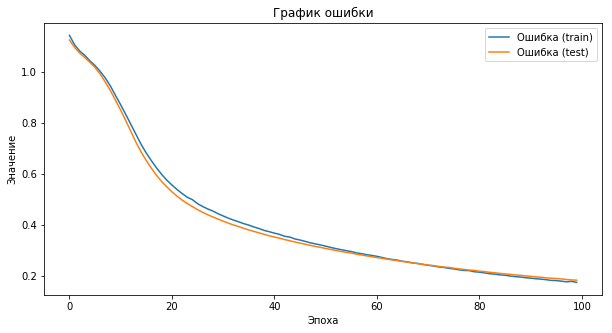

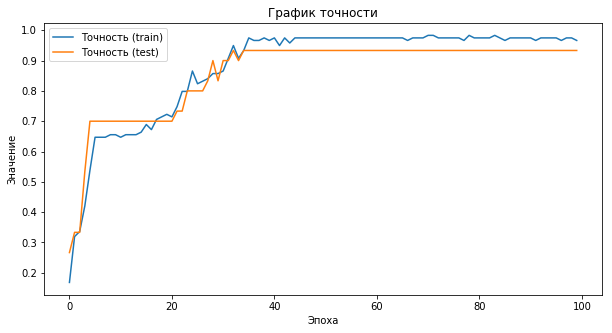

In [20]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [21]:
model = make_nn(number_data_read_X.shape[1], number_data_read_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_read_X,
    y=number_data_read_Y,
    batch_size=3,
    epochs=100,
    verbose=1,
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
    ]
)

Начинаем обучение сети
Train on 119 samples, validate on 30 samples
Epoch 1/100
119/119 [==============================] - 0s 2ms/step - loss: 0.9916 - categorical_accuracy: 0.8319 - val_loss: 1.2133 - val_categorical_accuracy: 0.0000e+00
Epoch 2/100
119/119 [==============================] - 0s 277us/step - loss: 0.9474 - categorical_accuracy: 0.8319 - val_loss: 1.2384 - val_categorical_accuracy: 0.0000e+00
Epoch 3/100
119/119 [==============================] - 0s 286us/step - loss: 0.9002 - categorical_accuracy: 0.8319 - val_loss: 1.2614 - val_categorical_accuracy: 0.0000e+00
Epoch 4/100
119/119 [==============================] - 0s 277us/step - loss: 0.8522 - categorical_accuracy: 0.8319 - val_loss: 1.2887 - val_categorical_accuracy: 0.0000e+00
Epoch 5/100
119/119 [==============================] - 0s 286us/step - loss: 0.8035 - categorical_accuracy: 0.8319 - val_loss: 1.2991 - val_categorical_accuracy: 0.0000e+00
Epoch 6/100
119/119 [==============================] - 0s 269us/step 

Epoch 48/100
119/119 [==============================] - 0s 269us/step - loss: 0.2888 - categorical_accuracy: 0.8655 - val_loss: 0.9794 - val_categorical_accuracy: 0.1000
Epoch 49/100
119/119 [==============================] - 0s 252us/step - loss: 0.2843 - categorical_accuracy: 0.8739 - val_loss: 0.9337 - val_categorical_accuracy: 0.1667
Epoch 50/100
119/119 [==============================] - 0s 260us/step - loss: 0.2801 - categorical_accuracy: 0.8908 - val_loss: 0.8886 - val_categorical_accuracy: 0.2667
Epoch 51/100
119/119 [==============================] - 0s 252us/step - loss: 0.2755 - categorical_accuracy: 0.8824 - val_loss: 0.8737 - val_categorical_accuracy: 0.2667
Epoch 52/100
119/119 [==============================] - 0s 261us/step - loss: 0.2709 - categorical_accuracy: 0.8908 - val_loss: 0.9016 - val_categorical_accuracy: 0.2333
Epoch 53/100
119/119 [==============================] - 0s 277us/step - loss: 0.2679 - categorical_accuracy: 0.8908 - val_loss: 0.8780 - val_categoric

119/119 [==============================] - 0s 252us/step - loss: 0.1505 - categorical_accuracy: 0.9664 - val_loss: 0.5558 - val_categorical_accuracy: 0.7333
Epoch 97/100
119/119 [==============================] - 0s 269us/step - loss: 0.1490 - categorical_accuracy: 0.9664 - val_loss: 0.5325 - val_categorical_accuracy: 0.7333
Epoch 98/100
119/119 [==============================] - 0s 277us/step - loss: 0.1489 - categorical_accuracy: 0.9664 - val_loss: 0.5767 - val_categorical_accuracy: 0.7333
Epoch 99/100
119/119 [==============================] - 0s 269us/step - loss: 0.1443 - categorical_accuracy: 0.9664 - val_loss: 0.5486 - val_categorical_accuracy: 0.7333
Epoch 100/100
119/119 [==============================] - 0s 261us/step - loss: 0.1438 - categorical_accuracy: 0.9580 - val_loss: 0.5186 - val_categorical_accuracy: 0.7333


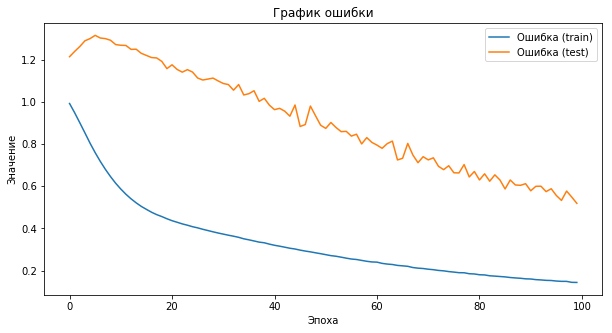

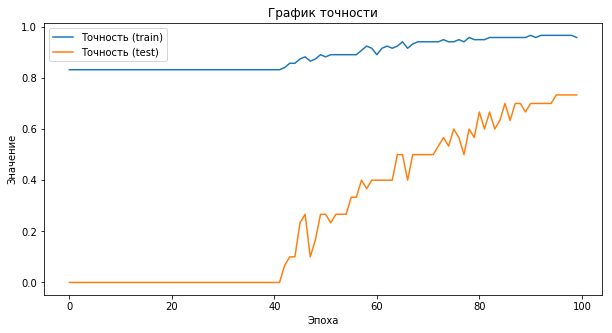

In [22]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [23]:
model = make_nn(number_data_read_X.shape[1], number_data_read_Y.shape[1])

print('Начинаем обучение сети')
history = model.fit(
    x=number_data_read_X,
    y=number_data_read_Y,
    batch_size=3,
    epochs=300,
    verbose=1,
    validation_split=0.2,
    callbacks=[
        callbacks.History(),
        callbacks.EarlyStopping(
            monitor = 'val_categorical_accuracy',
            mode='max',
            patience=50,
            min_delta=0.01,
        )
    ]
)

Начинаем обучение сети
Train on 119 samples, validate on 30 samples
Epoch 1/300
119/119 [==============================] - 0s 3ms/step - loss: 1.0774 - categorical_accuracy: 0.4706 - val_loss: 1.2973 - val_categorical_accuracy: 0.0000e+00
Epoch 2/300
119/119 [==============================] - 0s 378us/step - loss: 1.0386 - categorical_accuracy: 0.7143 - val_loss: 1.3153 - val_categorical_accuracy: 0.0000e+00
Epoch 3/300
119/119 [==============================] - 0s 378us/step - loss: 1.0093 - categorical_accuracy: 0.7983 - val_loss: 1.3353 - val_categorical_accuracy: 0.0000e+00
Epoch 4/300
119/119 [==============================] - 0s 361us/step - loss: 0.9837 - categorical_accuracy: 0.8319 - val_loss: 1.3500 - val_categorical_accuracy: 0.0000e+00
Epoch 5/300
119/119 [==============================] - 0s 345us/step - loss: 0.9587 - categorical_accuracy: 0.8319 - val_loss: 1.3707 - val_categorical_accuracy: 0.0000e+00
Epoch 6/300
119/119 [==============================] - 0s 345us/step 

Epoch 48/300
119/119 [==============================] - 0s 261us/step - loss: 0.3374 - categorical_accuracy: 0.8403 - val_loss: 0.9366 - val_categorical_accuracy: 0.0333
Epoch 49/300
119/119 [==============================] - 0s 252us/step - loss: 0.3334 - categorical_accuracy: 0.8487 - val_loss: 0.9224 - val_categorical_accuracy: 0.0667
Epoch 50/300
119/119 [==============================] - 0s 277us/step - loss: 0.3298 - categorical_accuracy: 0.8487 - val_loss: 0.9086 - val_categorical_accuracy: 0.1000
Epoch 51/300
119/119 [==============================] - 0s 261us/step - loss: 0.3263 - categorical_accuracy: 0.8571 - val_loss: 0.8973 - val_categorical_accuracy: 0.1000
Epoch 52/300
119/119 [==============================] - 0s 252us/step - loss: 0.3227 - categorical_accuracy: 0.8487 - val_loss: 0.8887 - val_categorical_accuracy: 0.1000
Epoch 53/300
119/119 [==============================] - 0s 261us/step - loss: 0.3191 - categorical_accuracy: 0.8655 - val_loss: 0.8788 - val_categoric

119/119 [==============================] - 0s 261us/step - loss: 0.2038 - categorical_accuracy: 0.9664 - val_loss: 0.6191 - val_categorical_accuracy: 0.6333
Epoch 97/300
119/119 [==============================] - 0s 269us/step - loss: 0.2033 - categorical_accuracy: 0.9664 - val_loss: 0.6731 - val_categorical_accuracy: 0.5667
Epoch 98/300
119/119 [==============================] - 0s 252us/step - loss: 0.1989 - categorical_accuracy: 0.9496 - val_loss: 0.6232 - val_categorical_accuracy: 0.6333
Epoch 99/300
119/119 [==============================] - 0s 269us/step - loss: 0.1970 - categorical_accuracy: 0.9664 - val_loss: 0.6120 - val_categorical_accuracy: 0.6667
Epoch 100/300
119/119 [==============================] - 0s 261us/step - loss: 0.1984 - categorical_accuracy: 0.9748 - val_loss: 0.6332 - val_categorical_accuracy: 0.5667
Epoch 101/300
119/119 [==============================] - 0s 261us/step - loss: 0.1932 - categorical_accuracy: 0.9748 - val_loss: 0.6248 - val_categorical_accuracy

119/119 [==============================] - 0s 269us/step - loss: 0.1272 - categorical_accuracy: 0.9832 - val_loss: 0.4760 - val_categorical_accuracy: 0.7667
Epoch 145/300
119/119 [==============================] - 0s 260us/step - loss: 0.1271 - categorical_accuracy: 0.9832 - val_loss: 0.4508 - val_categorical_accuracy: 0.8000
Epoch 146/300
119/119 [==============================] - 0s 261us/step - loss: 0.1251 - categorical_accuracy: 0.9916 - val_loss: 0.4352 - val_categorical_accuracy: 0.8000
Epoch 147/300
119/119 [==============================] - 0s 261us/step - loss: 0.1236 - categorical_accuracy: 0.9832 - val_loss: 0.4505 - val_categorical_accuracy: 0.8000
Epoch 148/300
119/119 [==============================] - 0s 286us/step - loss: 0.1243 - categorical_accuracy: 0.9916 - val_loss: 0.4920 - val_categorical_accuracy: 0.7667
Epoch 149/300
119/119 [==============================] - 0s 261us/step - loss: 0.1225 - categorical_accuracy: 0.9832 - val_loss: 0.4679 - val_categorical_accur

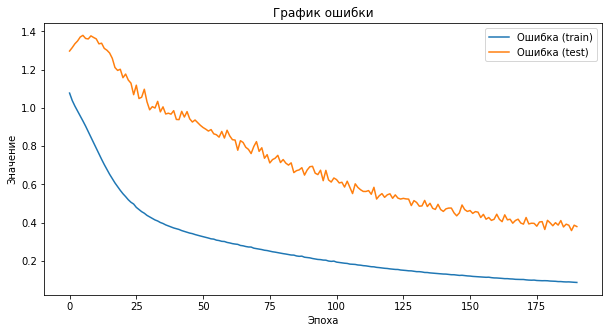

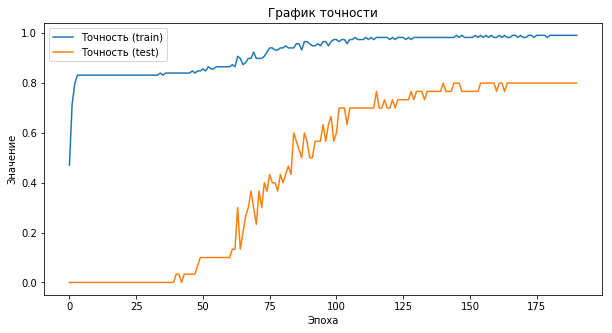

In [24]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [25]:
# 6 Контрольные точки
from pathlib import Path
from os import remove

In [27]:
# создаем функцию создания и очистки каталога Конт. точек
# указ. шаблон имени файла Контр. точки
file_name = 'nn_model_loss-{loss:.2f}_val_loss-{val_loss:.2f}_acc-{categorical_accuracy:.2f}_val_acc-{val_categorical_accuracy:.2f}.hdf5'
def make_save_points(name='save_points', file_name=file_name):
    # выбираем каталог 
    checkpoints_dir = Path('./').joinpath('save_points')
    print(f'Текущий каталог с контрольными точками {checkpoints_dir.absolute()}')
    # создаем каталог если его нету
    checkpoints_dir.mkdir(exist_ok=True)
    # удалеяем все из каталога 
    for item in checkpoints_dir.iterdir():
        if item.is_file():
            print(f'Удаляем файл {item}')
            remove(item)
    return str(checkpoints_dir.joinpath(file_name))

In [28]:
print('Начинаем обучение сети')
history = make_nn(X_train.shape[1], Y_train.shape[1]).fit(
    x=X_train,
    y=Y_train,
    batch_size=3,
    epochs=300,
    validation_split=0.2,
    verbose=1,
    callbacks=[
        callbacks.History(),
        # добаляем сценарий ранней остановки
        # если в течении 30 эпох точность не выростит более чем на 1%, то произойдет остановка
        callbacks.EarlyStopping(
            monitor='val_categorical_accuracy',
            mode='max',
            patience=50,
            min_delta=0.01
        ),
        # Callback сохраняет состояние сети
        callbacks.ModelCheckpoint(
            # указываем путь для сохранения и формат имени файла
            make_save_points(file_name=file_name),
            # указиваем какое значение отсеживать
            monitor='val_categorical_accuracy',
            # указываем, что сохранить надо только лучший результат
            save_best_only=True,
            # указываем как часто проверять, что текущий результат лучше предыдущего (в эпохах)
            period=5,
            # указываем сторону лучших значений
            mode='max'
        )
    ]
)

Начинаем обучение сети
Текущий каталог с контрольными точками C:\Users\skydi\save_points
Train on 95 samples, validate on 24 samples
Epoch 1/300
95/95 [==============================] - 0s 3ms/step - loss: 1.2511 - categorical_accuracy: 0.3579 - val_loss: 1.3098 - val_categorical_accuracy: 0.1667
Epoch 2/300
95/95 [==============================] - 0s 369us/step - loss: 1.1716 - categorical_accuracy: 0.3474 - val_loss: 1.2099 - val_categorical_accuracy: 0.1667
Epoch 3/300
95/95 [==============================] - 0s 339us/step - loss: 1.1102 - categorical_accuracy: 0.3474 - val_loss: 1.1467 - val_categorical_accuracy: 0.2500
Epoch 4/300
95/95 [==============================] - 0s 316us/step - loss: 1.0646 - categorical_accuracy: 0.5789 - val_loss: 1.1062 - val_categorical_accuracy: 0.4583
Epoch 5/300
95/95 [==============================] - 0s 347us/step - loss: 1.0260 - categorical_accuracy: 0.6947 - val_loss: 1.0621 - val_categorical_accuracy: 0.4583
Epoch 6/300
95/95 [===============

95/95 [==============================] - 0s 253us/step - loss: 0.3635 - categorical_accuracy: 0.9158 - val_loss: 0.4562 - val_categorical_accuracy: 0.9583
Epoch 50/300
95/95 [==============================] - 0s 263us/step - loss: 0.3584 - categorical_accuracy: 0.8947 - val_loss: 0.4530 - val_categorical_accuracy: 0.9167
Epoch 51/300
95/95 [==============================] - 0s 263us/step - loss: 0.3544 - categorical_accuracy: 0.8947 - val_loss: 0.4486 - val_categorical_accuracy: 0.9167
Epoch 52/300
95/95 [==============================] - 0s 263us/step - loss: 0.3514 - categorical_accuracy: 0.9053 - val_loss: 0.4432 - val_categorical_accuracy: 0.9583
Epoch 53/300
95/95 [==============================] - 0s 263us/step - loss: 0.3475 - categorical_accuracy: 0.9053 - val_loss: 0.4387 - val_categorical_accuracy: 0.9583
Epoch 54/300
95/95 [==============================] - 0s 263us/step - loss: 0.3448 - categorical_accuracy: 0.9053 - val_loss: 0.4350 - val_categorical_accuracy: 0.9583
Epoch

Epoch 98/300
95/95 [==============================] - 0s 263us/step - loss: 0.2382 - categorical_accuracy: 0.9579 - val_loss: 0.2555 - val_categorical_accuracy: 0.9583
Epoch 99/300
95/95 [==============================] - 0s 253us/step - loss: 0.2348 - categorical_accuracy: 0.9474 - val_loss: 0.2472 - val_categorical_accuracy: 1.0000
Epoch 100/300
95/95 [==============================] - 0s 274us/step - loss: 0.2346 - categorical_accuracy: 0.9474 - val_loss: 0.2437 - val_categorical_accuracy: 1.0000
Epoch 101/300
95/95 [==============================] - 0s 263us/step - loss: 0.2310 - categorical_accuracy: 0.9474 - val_loss: 0.2459 - val_categorical_accuracy: 0.9583
Epoch 102/300
95/95 [==============================] - 0s 263us/step - loss: 0.2305 - categorical_accuracy: 0.9579 - val_loss: 0.2416 - val_categorical_accuracy: 1.0000
Epoch 103/300
95/95 [==============================] - 0s 263us/step - loss: 0.2277 - categorical_accuracy: 0.9579 - val_loss: 0.2417 - val_categorical_accur

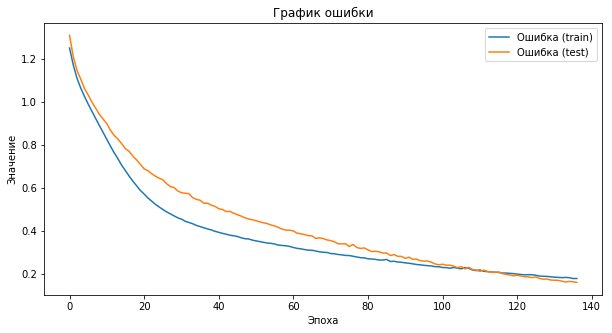

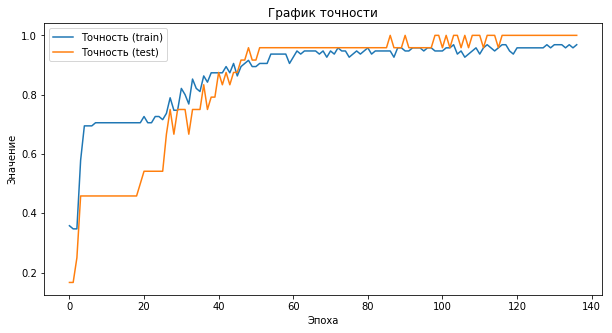

In [29]:
plt.figure(0, figsize=(10,5))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('График ошибки')
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.legend(['Ошибка (train)', 'Ошибка (test)']);

plt.figure(1, figsize=(10,5))
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.ylabel('Значение')
plt.xlabel('Эпоха')
plt.title('График точности')
plt.legend(['Точность (train)', 'Точность (test)']);

In [31]:
from keras.models import load_model

# загружаем контрольную точку(модель)
# путь до К.т может отличатся
loaded_model = load_model('C:/Users/skydi/save_points/nn_model_loss-0.23_val_loss-0.24_acc-0.95_val_acc-1.00.hdf5')

# предсказываем класс
print(f'Точность предсказания на тренировочных данных {loaded_model.evaluate(X_train, Y_train)[1]}')
print(f'Точность предсказания на тестовых данных {loaded_model.evaluate(X_test, Y_test)[1]}')
predict = loaded_model.predict_classes(X_test)
predict

119/119 [==============================] - 0s 696us/step
Точность предсказания на тренировочных данных 0.957983193277311
30/30 [==============================] - 0s 0us/step
Точность предсказания на тестовых данных 0.9333333373069763


array([2, 1, 1, 0, 2, 0, 0, 0, 2, 1, 0, 0, 2, 1, 2, 0, 0, 2, 0, 2, 2, 1,
       0, 1, 2, 2, 2, 0, 1, 2], dtype=int64)

In [33]:
# преобразуем классы, в виде числа, в их оригиналы
pipe_y.named_steps['label_encoder'].inverse_transform(predict)

array(['Iris-virginica', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-setosa', 'Iris-virginica', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-virginica', 'Iris-versicolor', 'Iris-setosa',
       'Iris-setosa', 'Iris-virginica', 'Iris-versicolor',
       'Iris-virginica', 'Iris-setosa', 'Iris-setosa', 'Iris-virginica',
       'Iris-setosa', 'Iris-virginica', 'Iris-virginica',
       'Iris-versicolor', 'Iris-setosa', 'Iris-versicolor',
       'Iris-virginica', 'Iris-virginica', 'Iris-virginica',
       'Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [34]:
# предсказываем вероятности для классов
loaded_model.predict(X_train)

array([[9.94964004e-01, 4.91912430e-03, 1.16933465e-04],
       [9.57377633e-05, 1.23349331e-01, 8.76554966e-01],
       [9.92254376e-01, 7.66323786e-03, 8.22861839e-05],
       [9.94541466e-01, 5.39644016e-03, 6.21447543e-05],
       [9.87679183e-01, 1.20696425e-02, 2.51158228e-04],
       [9.94698763e-01, 5.21669677e-03, 8.45088725e-05],
       [9.90281105e-01, 9.54953674e-03, 1.69269901e-04],
       [3.41144167e-02, 7.97075152e-01, 1.68810412e-01],
       [9.91722167e-01, 8.15633778e-03, 1.21498364e-04],
       [5.48090793e-06, 4.02106345e-02, 9.59783852e-01],
       [7.97222820e-05, 1.36447325e-01, 8.63472998e-01],
       [3.63014231e-04, 3.07753056e-01, 6.91883981e-01],
       [9.79197443e-01, 2.02912502e-02, 5.11388178e-04],
       [2.09412421e-04, 3.11519563e-01, 6.88271105e-01],
       [1.02348002e-02, 6.14479065e-01, 3.75286102e-01],
       [1.44340647e-02, 6.93118274e-01, 2.92447746e-01],
       [1.58368237e-03, 3.31196338e-01, 6.67219937e-01],
       [1.22169149e-04, 1.83500

In [41]:
# Визуализыция классов
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min()-1, x.max()+1
    y_min, y_max = y.min()-1, y.max()+1
    xx, yy, = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf(xx, yy)
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

(149, 2)


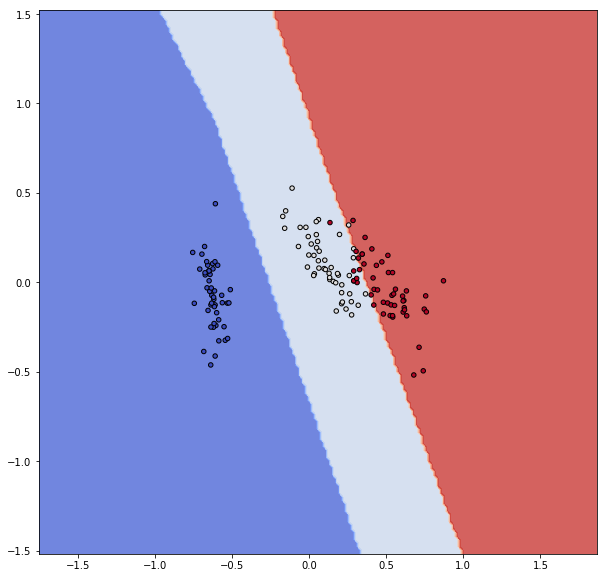

In [42]:
from sklearn.decomposition import PCA
pipe_y_mini = pipeline.Pipeline([
    ('to_martix', PandasToNumpy()),
    ('label_encoder', ModifyLabelEncoder()),
])

Y =  pipe_y_mini.fit_transform(outletless_data_Y)
X = number_data_read_X

pca = PCA(n_components=2)

_X = pca.fit_transform(X)
print(_X.shape)

clf_predict = lambda xx, yy: model.predict_classes(pca.inverse_transform(np.c_[xx.ravel(), yy.ravel()]))

X0, X1 = _X[:, 0], _X[:, 1]
xx, yy = make_meshgrid(X0, X1)

clf_predict(xx, yy)

fig, ax = plt.subplots(1,1, figsize=(10,10))
plot_contours(ax, clf_predict, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
ax.scatter(X0, X1, c=Y, cmap=plt.cm.coolwarm, s=20, edgecolors='k')